In [1]:
import os
import torch
import numpy as np

import json, argparse
from include.utils import DotDic, plot_learning_curve

from include.SAC import *
from Environment import Environment

In [2]:
parser = argparse.ArgumentParser()

parser.add_argument("--seed", default=13, type=int)
parser.add_argument("--gamma", default=0.99, type=float)
parser.add_argument("--tau", default=0.005, type=float)
parser.add_argument("--buffer_size", default=1000000, type=int)
parser.add_argument("--reward_scale", default=2, type=int)
parser.add_argument('--actor_lr', type=float, default=3e-4)  # learning rate
parser.add_argument('--critic_lr', type=float, default=1e-3)  # learning rate
parser.add_argument('--value_lr', type=float, default=1e-3)  # learning rate
parser.add_argument("--batch_size", default=64, type=int)  # Batch size for both actor and critic
parser.add_argument('--actor_hidden', type=list, default=[512, 256])
parser.add_argument('--critic_hidden', type=list, default=[512, 256])
parser.add_argument('--value_hidden', type=list, default=[512, 256])
parser.add_argument('--model_path', type=str, default="./SAC Training")

parser.add_argument('-c1', '--config_scenario', default='./configs/scenario.json', type=str, help='path to existing scenarionarios file')
args = parser.parse_args(args=[])

if not os.path.exists('%s/' % (args.model_path)):
  os.makedirs('%s/' % (args.model_path))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
scenario = DotDic(json.loads(open(args.config_scenario, 'r').read()))

In [3]:
# Environment action and states
K = scenario.K_t + scenario.K_r
L = scenario.L_t + scenario.L_r

# Actions: (Re{w_k}, Im{w_k}), (Re{u_l}, Im{u_l}), (theta_r, theta_t), rho_l
action_size =   (2 * K * scenario.Nt) + \
                (2 * L * scenario.Nt) + \
                (2 * scenario.R * scenario.Mr) + L

# States:  h, g, h_s, g_s, H, f, STR
state_size =    (scenario.Nt * K) + (scenario.Nt * L) + \
                (scenario.Mr * scenario.R * K) + \
                (scenario.Mr * scenario.R * L) + \
                (scenario.Mr * scenario.Nt * scenario.R) + \
                (L * K) + 1

max_action = 1

print(f'Action size is: {action_size}, \nState size is: {state_size}.')

Action size is: 131, 
State size is: 434.


In [4]:
# create the environment
env = Environment(scenario, state_size, action_size)
env_test = Environment(scenario, state_size, action_size)

# Create a DDPG instance
agent = SAC(state_size, action_size, max_action, args)
agent_test = SAC(state_size, action_size, max_action, args)

# for reproducibility
# env.set_seed(args.seed)
torch.manual_seed(args.seed)
# np.random.seed(args.seed)

## Train

In [5]:
ep_r = 0
score_hist = []

train_episode = 200
max_steps = 500
trainig_iteration = 32

# Train the agent for max_episodes
for e in range(train_episode):
    done = 0
    total_reward = 0
    state = env.reset()
    
    print(f'Training: \n\t episode {e+1}/{train_episode} ...')
    for t in range(max_steps):

        action = agent.select_action(state)
            
        phi_r, phi_t, rho, w, u = env.action_cal(action)
        next_state, reward, done, info = env.step(phi_r, phi_t, rho, w, u)

        agent.replay_buffer.push(state, next_state, action, reward, done)
        agent.train()
        
        state = next_state
        total_reward += reward

        if done:
            print(f'\t done in step {t+1}')
            break
        elif t==max_steps-1:
            print('\t Not done !')
        
    score_hist.append(total_reward)

    print("\t Total Reward: {:0.2f} ".format(total_reward))
    
    
    if e % 50 == 0:
        agent.save()

Training: 
	 episode 1/200 ...


d:\learning\EE Courses\Master\Distributed Optimization and Learning\Homework\Prj 3\Multi-agent-Reinforcement-learning-in-wireless-network-system\include\SAC.py:200: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  state = T.Tensor([observation]).to(self.actor.device)


	 Not done !
	 Total Reward: -3332342199.43 
 Model has been saved...
Training: 
	 episode 2/200 ...
	 done in step 471
	 Total Reward: -3136081504.02 
Training: 
	 episode 3/200 ...
	 done in step 2
	 Total Reward: -5529789.46 
Training: 
	 episode 4/200 ...
	 Not done !
	 Total Reward: -4883175426.44 
Training: 
	 episode 5/200 ...
	 done in step 1
	 Total Reward: 7820587.68 
Training: 
	 episode 6/200 ...
	 done in step 1
	 Total Reward: 9566329.65 
Training: 
	 episode 7/200 ...
	 done in step 1
	 Total Reward: 9069926.85 
Training: 
	 episode 8/200 ...
	 done in step 1
	 Total Reward: 8503096.05 
Training: 
	 episode 9/200 ...
	 done in step 1
	 Total Reward: 8043383.27 
Training: 
	 episode 10/200 ...
	 done in step 1
	 Total Reward: 9598786.00 
Training: 
	 episode 11/200 ...
	 done in step 1
	 Total Reward: 8062102.05 
Training: 
	 episode 12/200 ...
	 done in step 1
	 Total Reward: 8971095.73 
Training: 
	 episode 13/200 ...
	 done in step 1
	 Total Reward: 9740584.45 
Trainin

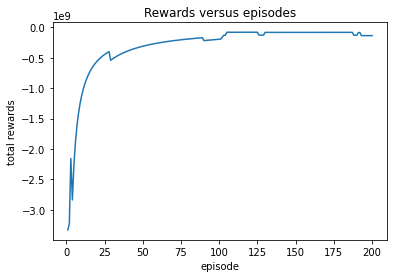

In [6]:
plot_learning_curve(score_hist)

## Test

In [7]:
test_episode = 100
max_steps = 500
score_hist_test = []


for e in range(test_episode):
    done = 0
    total_reward = 0
    state = env_test.reset()
    agent_test.load()

    print(f'Testing: \n\t episode {e+1}/{test_episode} ...')
    for t in range(max_steps):

        action = agent.select_action(state)
            
        phi_r, phi_t, rho, w, u = env.action_cal(action)
        next_state, reward, done, info = env.step(phi_r, phi_t, rho, w, u)
        
        state = next_state
        total_reward += reward

        if done:
            print(f'\t done in step {t+1}')
            break
        elif t==max_steps-1:
            print('\t Not done !')
        
    score_hist_test.append(total_reward)

    print("\t Total Reward: {:0.2f} ".format(total_reward))

 model has been loaded...
Testing: 
	 episode 1/100 ...
	 done in step 1
	 Total Reward: 9116223.34 
 model has been loaded...
Testing: 
	 episode 2/100 ...
	 done in step 1
	 Total Reward: 8702145.22 
 model has been loaded...
Testing: 
	 episode 3/100 ...
	 done in step 1
	 Total Reward: 9310993.73 
 model has been loaded...
Testing: 
	 episode 4/100 ...
	 done in step 1
	 Total Reward: 9319784.31 
 model has been loaded...
Testing: 
	 episode 5/100 ...
	 done in step 1
	 Total Reward: 9076712.21 
 model has been loaded...
Testing: 
	 episode 6/100 ...
	 done in step 1
	 Total Reward: 9216357.45 
 model has been loaded...
Testing: 
	 episode 7/100 ...
	 done in step 1
	 Total Reward: 9321402.62 
 model has been loaded...
Testing: 
	 episode 8/100 ...
	 done in step 1
	 Total Reward: 9121443.38 
 model has been loaded...
Testing: 
	 episode 9/100 ...
	 done in step 1
	 Total Reward: 8754629.58 
 model has been loaded...
Testing: 
	 episode 10/100 ...
	 done in step 1
	 Total Reward: 9

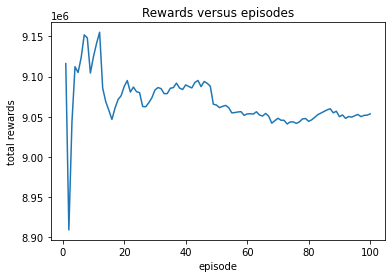

In [8]:
plot_learning_curve(score_hist_test)